# Heiner classifier
ReLU activation, 4 layers, 100 neurons per layer
Validation score use ensemble of 10 models weighted by loss

### TODO:

- What metrics to use during training?
- Which plots are needed?


### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import tensorflow as tf
import sys
import os
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *
from keras.models import load_model

dirLoc = '../Data/'
name = "weights/ReLU_Baseline_CLR_AsimovLoss"
#dirLoc = '../Data_3Fold/'
#name = "weights/ReLU_Baseline_CLR_AsimovLoss_3Fold"

name_pretrain = name.replace('weights/', 'weights/PRETRAIN_')

Using TensorFlow backend.


## Options

In [2]:
with open(dirLoc + 'features.pkl', 'rb') as fin:
    classTrainFeatures = pickle.load(fin)

In [3]:
nSplits = 10
patience = 50
maxEpochs = 200
preTrainMaxEpochs = 10

ensembleSize = 10
ensembleMode = 'loss'

compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':'modelRelu', 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

plot_while_training=True

print ("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])


# b = 100000  # test
# t = 250000  # training
# v = 450000  # test

# sig weight sum:  1383.97719575 in 550000
# bkg weight sum:  821999.696026 in 550000

# expected signal and background numbers
s_exp = 691.988607714
b_exp = 410999.847322
print ('_S%.2e'%s_exp).replace('.', 'd').replace('+','p').replace('-','m')
print ('_B%.2e'%b_exp).replace('.', 'd').replace('+','p').replace('-','m')

new_loss_functions = get_losses_dict([0.001, 0.1, 0.3, 0.5], s_exp, b_exp)

def plotLoss(history):
    val_loss = history['val_loss']
    plt.plot(history['val_train_loss'],label='train')
    plt.plot(val_loss,label='test')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if max(val_loss) > 20*min(val_loss) and min(val_loss)>0:
        plt.yscale('log')
    plt.legend(loc='best')
#    plt.savefig(os.path.join(self.output,'lossEvolution.pdf'))
#    plt.clf()
    plt.show()

('\nTraining on', 31, 'features:', ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py'])
_S6d92ep02
_B4d11ep05


## Import data

In [4]:
trainData          = BatchYielder(h5py.File(dirLoc + 'train.hdf5', "r+"))
trainDataTargetMod = BatchYielderTargetMod(h5py.File(dirLoc + 'train.hdf5', "r+"))
nSplits = trainData.nFolds

## Determine LR


______________________________________
Training finished
Cross-validation took 8.386s 


/nfs/dust/cms/user/tholenhe/installs/anaconda2/envs/hepML3/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


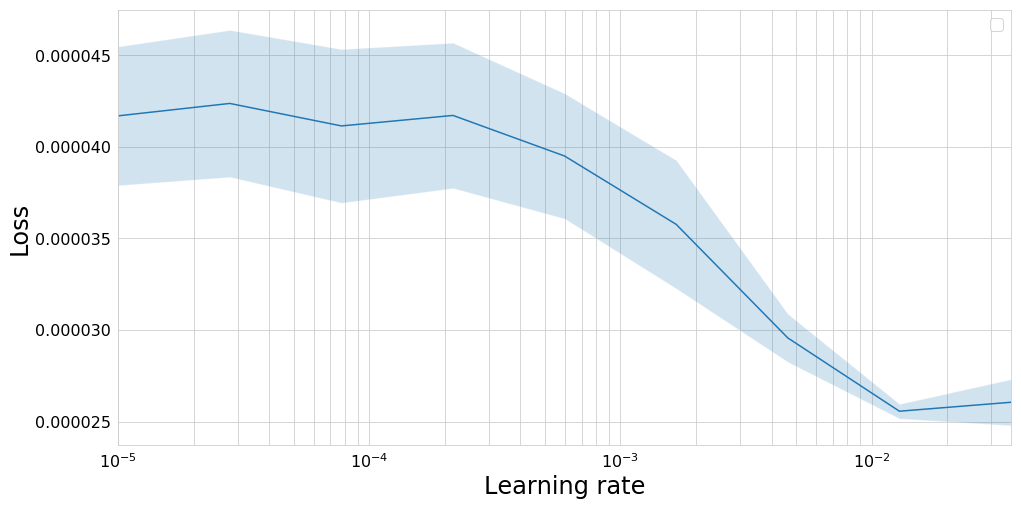

______________________________________



In [14]:
def my_model(**_):
    return model


newModelArgs = modelParams.copy()
newModelArgs['compileArgs'] = compileArgs.copy()
newModelArgs['compileArgs']['lr'] = 1e-3
trainParams['batch_size'] = 256
patience = 20  # is 50 above

loss = new_loss_functions['asimovSignificanceLossInvert_Sys0p5_S6d92ep02_B4d11ep05']
#loss = new_loss_functions['significanceLoss2Invert_S6d92ep02_B4d11ep05']
#loss = new_loss_functions['sOverBLossInvert_S2d01ep03_B1d20ep06']
#loss = new_loss_functions['sMinusBLossInvert_S2d01ep03_B1d20ep06']
newModelArgs['compileArgs']['lr'] = 1e-10
newModelArgs['compileArgs']['loss'] = loss
trainParams['batch_size'] = 8192

# d = trainData
d = trainDataTargetMod

lrFinder = batchLRFind(d, getModel, newModelArgs, trainParams,# allFolds=False,
                       lrBounds=[1e-5,1e-1], trainOnWeights=True, verbose=0, binary=True)

## Train classifier

<b>Asimov-significance-loss 0.5</b> training with ``maxEpochs``

In [5]:
def _get_s_b(s_exp, b_exp, y_true, y_pred):

    # unfold encoded weights
    weights = K.abs(y_true)
    s_weights = (weights + y_true)/2.
    b_weights = (weights - y_true)/2.

    s_exp_weight = s_exp/(K.sum(s_weights)+K.epsilon())
    b_exp_weight = b_exp/(K.sum(b_weights)+K.epsilon())

    s = s_exp_weight * K.sum(y_pred * s_weights)
    b = b_exp_weight * K.sum(y_pred * b_weights)
    return s, b


def asimovSignificanceLossInvert(syst_factr, s_exp=None, b_exp=None):
    '''Define a loss function that calculates the significance based on fixed
    expected signal and expected background yields for a given batch size

    s_exp and b_exp are the number of recorded signal and background events,
    respectively (xsec*lumi).'''

    #@_patch_with_weights
    def asimovSigLossInvert(y_true, y_pred):
        s, b = _get_s_b(s_exp, b_exp, y_true, y_pred)
        
        
        #s = K.print_tensor(s, 's=')
        #b = K.print_tensor(b, 'b=')

        # coding dataflow according to:
        # https://stackoverflow.com/questions/33712178/tensorflow-nan-bug/42497444#42497444

        # sanity table 0.5: 
        # s_min | b_max
        # 1     | 200
        # 10    | 1000
        # 100   | 4000
        # 1000  | 20000
        # 10000 | 100000
        
        # sanity table 0.3: 
        # s_min | b_max
        # 1     | 300
        # 10    | 1500
        # 100   | 7000
        # 1000  | 30000
        # 10000 | 125000

        # sanity table 0.1: 
        # s_min | b_max
        # 1     | 600
        # 10    | 3000
        # 100   | 15000
        # 1000  | 60000
        # 10000 | 300000
        
        s_b_ok = K.any(K.stack([
            K.all(K.stack([K.greater(600.,    b), K.greater(s, 1.)])),
            K.all(K.stack([K.greater(3000.,   b), K.greater(s, 10.)])),
            K.all(K.stack([K.greater(1500.,   b), K.greater(s, 100.)])),
            K.all(K.stack([K.greater(60000.,  b), K.greater(s, 1000.)])),
            K.all(K.stack([K.greater(300000., b), K.greater(s, 10000.)])),
        ]))
        s_b_ok = K.print_tensor(s_b_ok, 's_b_ok=')
        
        sb = K.stack([s,b])
        sb = K.print_tensor(sb, 'sb=')
        
        def inner_loss(sb):
            s, b = sb[0], sb[1]
            spb = s+b
            b2 = b*b
            syst = syst_factr * b
            syst2 = syst*syst
            bpsyst2 = b+syst2            
            return 0.5/(
                spb * K.log((spb*bpsyst2+K.epsilon())/(b2+spb*syst2+K.epsilon())+K.epsilon())
                -b2/(syst2+K.epsilon()) * K.log(1+syst2*s/(b*bpsyst2+K.epsilon()))
            )
        
            #return 0.5 / K.log(
            #     K.pow(spb*bpsyst2/(b2+spb*syst2), spb)
            #    *K.pow(1 + syst2*s/(b2+b*syst2),   -b2/(syst2+K.epsilon()))
            #)
        
        def safe_inner_loss(sb):
            s, b = sb[0], sb[1]
            return (s+b)/(s*s+K.epsilon())   # s/sqrt(s+b) is safe enough
        
        #safe_sb = K.switch(s_b_ok, sb, K.ones(sb.shape))
        return K.switch(s_b_ok, inner_loss(sb), safe_inner_loss(sb))
        
    return asimovSigLossInvert

    
def get_losses_dict(syst_factors, s_exp=None, b_exp=None):
    post_fix  = ('_S%.2e'%s_exp) if s_exp else ''
    post_fix += ('_B%.2e'%b_exp) if b_exp else ''
    for before, after in (('.', 'd'), ('+','p'), ('-','m')):
        post_fix = post_fix.replace(before, after)

    d = {}
    d.update({
        (
            ('asimovSignificanceLossInvert_Sys%s'%sf).replace('.','p')+post_fix,
                asimovSignificanceLossInvert(sf, s_exp, b_exp)
        )
        for sf in syst_factors
    })

    # for keras to find the find the functions on load, the need to be named
    for func_name, func in d.iteritems():
        func.__name__ = func_name

    return d


new_loss_functions.update(get_losses_dict([0.001, 0.1, 0.3, 0.5], s_exp, b_exp))

In [6]:
newModelArgs = modelParams.copy()
loss = new_loss_functions['asimovSignificanceLossInvert_Sys0p1_S6d92ep02_B4d11ep05']
#loss = new_loss_functions['significanceLoss2Invert_S6d92ep02_B4d11ep05']
newModelArgs['compileArgs']['lr'] = 5e-3
newModelArgs['compileArgs']['loss'] = loss
#newModelArgs['compileArgs']['l2'] = 0.01
newModelArgs['compileArgs']['do'] = 0.1
trainParams['batch_size'] = 8192

new_model = getModel(**newModelArgs)
#new_model.set_weights(model.get_weights())
model = new_model

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`



In [7]:
results, histories = batchTrainClassifier(trainDataTargetMod, nSplits, lambda: model, {},  # model exist already
                                          trainParams, trainOnWeights=True, maxEpochs=maxEpochs,
                                          cosAnnealMult=2, reduxDecay=1,  # this line added
                                          patience=patience, verbose=1, amsSize=250000, binary=True,
                                          plotLR=plot_while_training, # plotMomentum=plot_while_training, 
                                          plot=plot_while_training, 
                                          stopIfStallingTest=15,
                                         )

Using cosine annealing
Training using weights
Running fold 1 / 10
.
1 New best found: 19420.2210679
.
2 New best found: 14378.8251255
.
3 New best found: 2410.59192509
.
4 New best found: 14.834363675
.
5 New best found: 0.0100139639633
.
6 New best found: 0.000227948627124
.
7 New best found: 0.000122502741037
.
8 New best found: 5.01343185812e-05
.
9 New best found: 4.61157997585e-05
............Learning process stalled at 0.00027373123385232643. Stopping...
.Learning process stalled at 0.0040133697405596086. Stopping...
.Learning process stalled at 0.06557733298013686. Stopping...
.Learning process stalled at 0.5113212141091653. Stopping...
.Learning process stalled at 3.713441471467264. Stopping...
.Learning process stalled at 8.889971503985583. Stopping...
.Learning process stalled at 8.977457145898875. Stopping...
Score is: {'loss': 4.6115799758533346e-05, 'AUC': 0.21903012607662697, 'cut': 0.9988365769386292, 'wAUC': 0.12751208502154732, 'AMS': 2.0733971727607132}
Fold took 54.4

.
1 New best found: 162.265181732
................Learning process stalled at 165.87026412068394. Stopping...
.Learning process stalled at 166.01556714798477. Stopping...
Score is: {'loss': 162.26518173226836, 'AUC': 0.164825881061609, 'cut': 0.9660667777061462, 'wAUC': 0.09859981549041974, 'AMS': 3.21284614093822}
Fold took 32.626s

Running fold 10 / 10
.
1 New best found: 4186.0559273
.
2 New best found: 4177.28347256
.
3 New best found: 4171.29475972
.
4 New best found: 4159.85336766
.
5 New best found: 4150.9004969
............Learning process stalled at 4204.112701322663. Stopping...
.Learning process stalled at 4218.436619152999. Stopping...
Score is: {'loss': 4150.900496899755, 'AUC': 0.16920321956728568, 'cut': 0.7982401251792908, 'wAUC': 0.10342591958474834, 'AMS': 2.9084828611446536}
Fold took 33.797s


______________________________________
Training finished
Cross-validation took 601.943s 
Mean loss = 437 +- 392
Mean AUC = 0.172 +- 0.005
Mean cut = 0.75 +- 0.07
Mean wAUC = 0

In [8]:
n = name_pretrain+'_model_step3p1'

In [9]:
model.save(n+'.h5')
with open(n+'.pkl', 'w') as f:
    pickle.dump((results, histories), f)

In [8]:
model = load_model(n+'.h5', custom_objects=new_loss_functions)
with open(n+'.pkl') as f:
    results, histories = pickle.load(f)

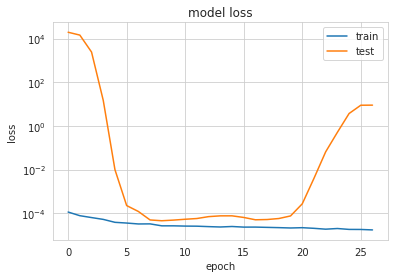

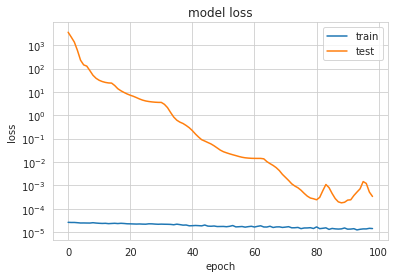

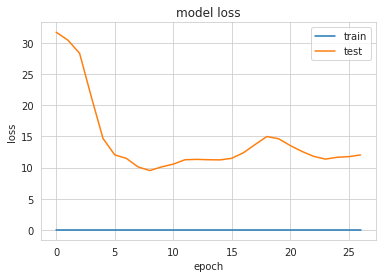

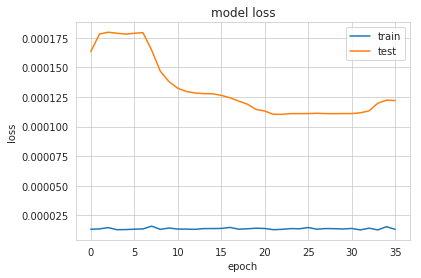

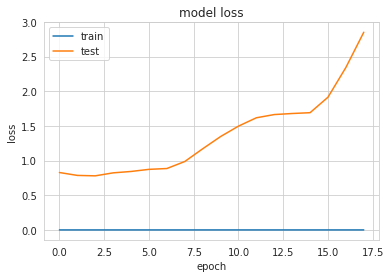

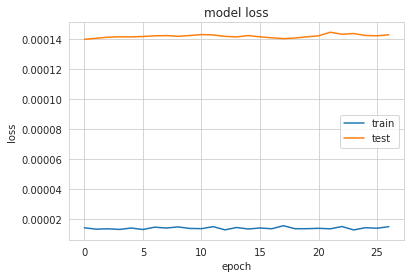

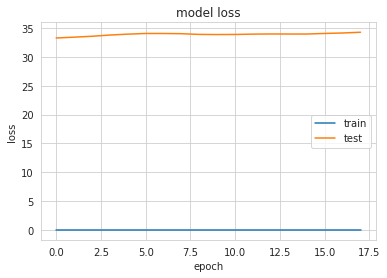

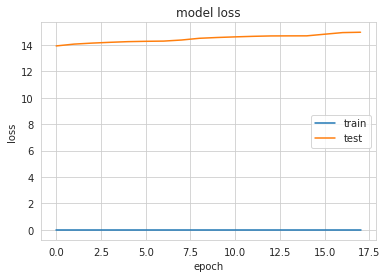

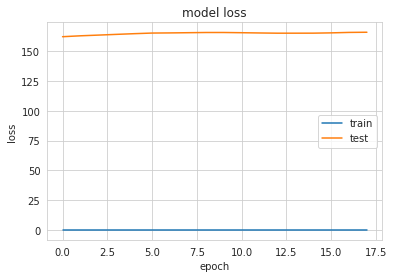

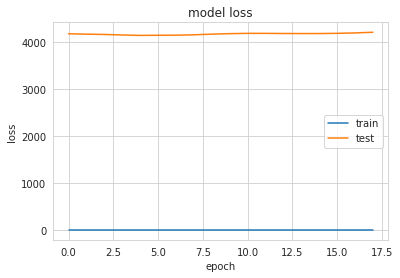

In [10]:
for i in range(len(histories)):
    plotLoss(histories[i])

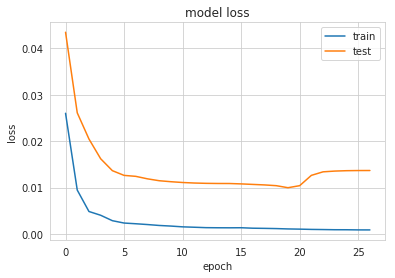

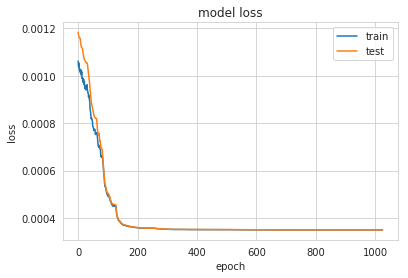

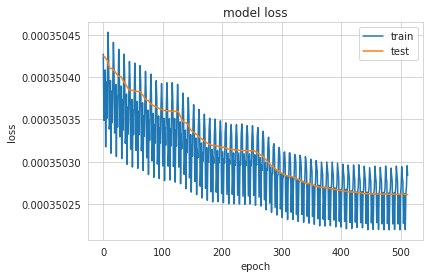

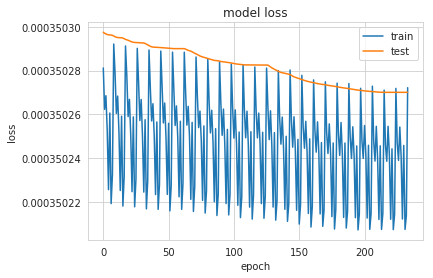

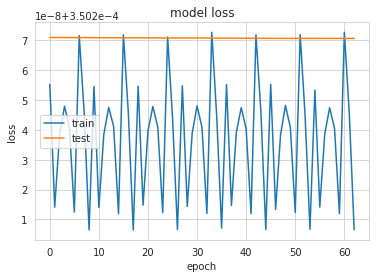

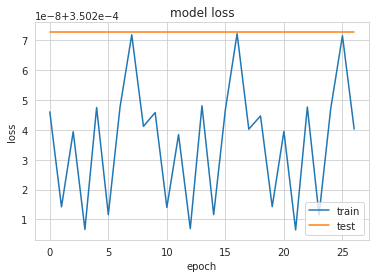

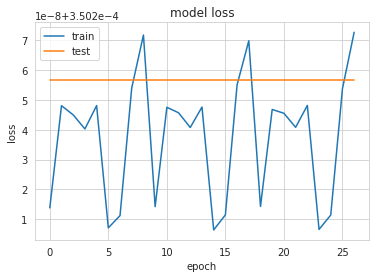

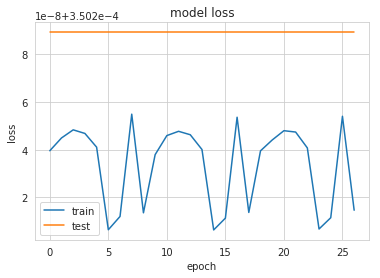

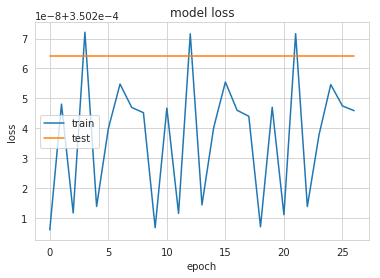

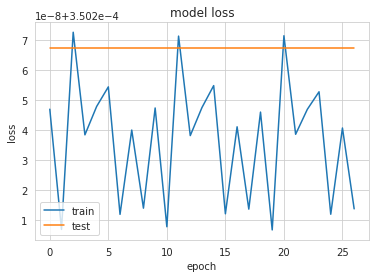

## Construct ensemble

In [11]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:
    results = pickle.load(fin)

In [12]:
ensemble, weights = assembleEnsemble(
    results, ensembleSize, ensembleMode, compileArgs, custom_objects=new_loss_functions)

('Choosing ensemble by', 'loss')
('Model', 0, 'is', 0, 'with', 'loss', '=', 4.6115799758533346e-05)
('Model', 1, 'is', 3, 'with', 'loss', '=', 0.00011037644538774885)
('Model', 2, 'is', 5, 'with', 'loss', '=', 0.00013962143257450918)
('Model', 3, 'is', 1, 'with', 'loss', '=', 0.0001811936038209908)
('Model', 4, 'is', 4, 'with', 'loss', '=', 0.7797704405796856)
('Model', 5, 'is', 2, 'with', 'loss', '=', 9.52725726604501)
('Model', 6, 'is', 7, 'with', 'loss', '=', 13.920101971222921)
('Model', 7, 'is', 6, 'with', 'loss', '=', 33.27608768627762)
('Model', 8, 'is', 8, 'with', 'loss', '=', 162.26518173226836)
('Model', 9, 'is', 9, 'with', 'loss', '=', 4150.900496899755)


## Response on validation datawith no ensembling

In [13]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [14]:
%%time
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=1, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.000122775173187s per sample

Predicting batch 2 out of 10
Prediction took 5.09637832642e-05s per sample

Predicting batch 3 out of 10
Prediction took 5.4221200943e-05s per sample

Predicting batch 4 out of 10
Prediction took 5.28217792511e-05s per sample

Predicting batch 5 out of 10
Prediction took 5.75135707855e-05s per sample

Predicting batch 6 out of 10
Prediction took 5.23639678955e-05s per sample

Predicting batch 7 out of 10
Prediction took 5.6164598465e-05s per sample

Predicting batch 8 out of 10
Prediction took 5.06746292114e-05s per sample

Predicting batch 9 out of 10
Prediction took 5.30605792999e-05s per sample

Predicting batch 10 out of 10
Prediction took 5.2577829361e-05s per sample

CPU times: user 13.8 s, sys: 50.7 s, total: 1min 4s
Wall time: 3.03 s


In [15]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source))))

Testing ROC AUC: unweighted 0.776928075184, weighted 0.867937648883


In [11]:
%%time
amsScanSlow(convertToDF(valData.source))

(50000, 'candidates loaded')
CPU times: user 19.2 s, sys: 0 ns, total: 19.2 s
Wall time: 41.5 s


(3.574477842890102, 0.9527582)

In [12]:
%%time
bootstrapMeanAMS(convertToDF(valData.source), N=512)

(50000, 'candidates loaded')

Mean AMS=3.6+-0.1, at mean cut of 0.95+-0.01
Exact mean cut 0.947619539453, corresponds to AMS of 3.52228979407
CPU times: user 2.71 s, sys: 10 s, total: 12.7 s
Wall time: 57.8 s


(3.6, 0.95)

# Test scoring with no ensembling

In [20]:
testData = BatchYielder(h5py.File(dirLoc + 'testing.hdf5', "r+"))

In [21]:
%%time
batchEnsemblePredict(ensemble, weights, testData, ensembleSize=1, verbose=1)

Predicting batch 1 out of 10
Prediction took 3.52311047641e-05s per sample

Predicting batch 2 out of 10
Prediction took 3.53069262071e-05s per sample

Predicting batch 3 out of 10
Prediction took 3.40793089433e-05s per sample

Predicting batch 4 out of 10
Prediction took 3.57414549047e-05s per sample

Predicting batch 5 out of 10
Prediction took 4.16354005987e-05s per sample

Predicting batch 6 out of 10
Prediction took 3.62087639895e-05s per sample

Predicting batch 7 out of 10
Prediction took 3.70459816673e-05s per sample

Predicting batch 8 out of 10
Prediction took 3.47492521459e-05s per sample

Predicting batch 9 out of 10
Prediction took 3.80688537251e-05s per sample

Predicting batch 10 out of 10
Prediction took 3.47301613201e-05s per sample

CPU times: user 1min 44s, sys: 5min 43s, total: 7min 27s
Wall time: 20 s


In [44]:
scoreTestOD(testData.source, 0.9417530075879768)

Public:Private AMS: 3.18253691892 : 3.22240702412


(3.1825369189224144, 3.222407024124467)

## Response on validation data with ensembling

In [31]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [32]:
%%time
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=ensembleSize, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00130655798912s per sample

Predicting batch 2 out of 10
Prediction took 0.000384625196457s per sample

Predicting batch 3 out of 10
Prediction took 0.000401422405243s per sample

Predicting batch 4 out of 10
Prediction took 0.000396262168884s per sample

Predicting batch 5 out of 10
Prediction took 0.000394056797028s per sample

Predicting batch 6 out of 10
Prediction took 0.00038629360199s per sample

Predicting batch 7 out of 10
Prediction took 0.000385829401016s per sample

Predicting batch 8 out of 10
Prediction took 0.000377050590515s per sample

Predicting batch 9 out of 10
Prediction took 0.000388145446777s per sample

Predicting batch 10 out of 10
Prediction took 0.000397673797607s per sample

CPU times: user 1min 54s, sys: 5min 53s, total: 7min 48s
Wall time: 24.1 s


In [18]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source))))

Testing ROC AUC: unweighted 0.897939621566, weighted 0.933283232346


In [19]:
amsScanSlow(convertToDF(valData.source))

(50000, 'candidates loaded')


(3.715117458996407, 0.9555341)

In [20]:
%%time
bootstrapMeanAMS(convertToDF(valData.source), N=512)

(50000, 'candidates loaded')

Mean AMS=3.8+-0.1, at mean cut of 0.95+-0.01
Exact mean cut 0.950024582446, corresponds to AMS of 3.69339872363
CPU times: user 2.59 s, sys: 9.73 s, total: 12.3 s
Wall time: 56.6 s


(3.8, 0.95)

# Test scoring

In [15]:
testData = BatchYielder(h5py.File(dirLoc + 'testing.hdf5', "r+"))

In [16]:
%%time
batchEnsemblePredict(ensemble, weights, testData, ensembleSize=ensembleSize, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.000381626436927s per sample

Predicting batch 2 out of 10
Prediction took 0.000325065690821s per sample

Predicting batch 3 out of 10
Prediction took 0.000332086307352s per sample

Predicting batch 4 out of 10
Prediction took 0.000326267415827s per sample

Predicting batch 5 out of 10
Prediction took 0.000327129546079s per sample

Predicting batch 6 out of 10
Prediction took 0.000323580308394s per sample

Predicting batch 7 out of 10
Prediction took 0.000327063855258s per sample

Predicting batch 8 out of 10
Prediction took 0.000326154544137s per sample

Predicting batch 9 out of 10
Prediction took 0.000326552473415s per sample

Predicting batch 10 out of 10
Prediction took 0.000326488633589s per sample

CPU times: user 15min 57s, sys: 52min 37s, total: 1h 8min 35s
Wall time: 3min 2s


In [23]:
scoreTestOD(testData.source, 0.9394347775960341)

Public:Private AMS: 3.6170575304 : 3.61021225312


(3.6170575303988963, 3.610212253117004)

# Save/Load

In [23]:
saveEnsemble(name, ensemble, weights, compileArgs, overwrite=True)

TypeError: <function asimovSignificanceLossInvert_Sys0p5_S6d92ep02_B4d11ep05 at 0x7f1d310197d0> is not JSON serializable

In [6]:
ensemble, weights, compileArgs, _, _ = loadEnsemble(name, custom_objects=new_loss_functions)

# Plotting

(50000, 'candidates loaded')


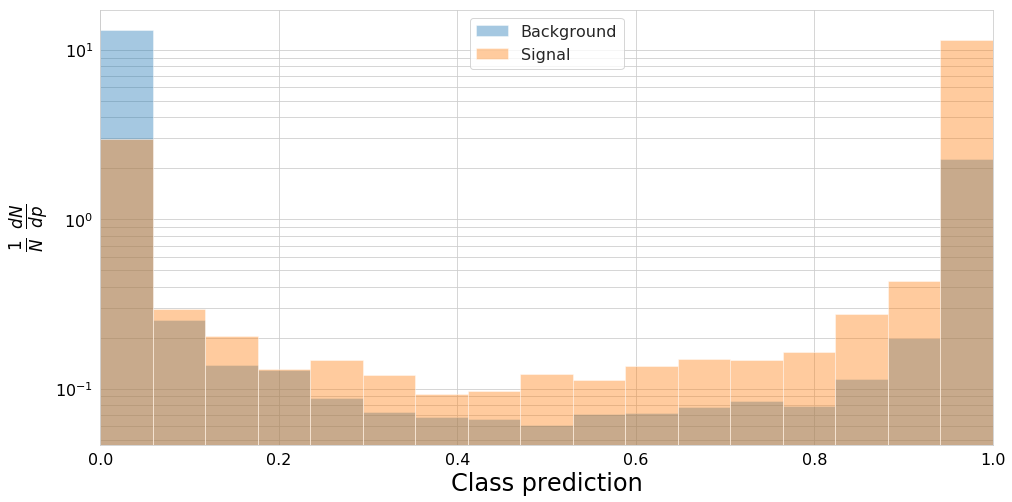

In [16]:
# TODO log-x

d = convertToDF(valData.source)
bkg_sig_dfs = [
    d[d['gen_target']==0],
    d[d['gen_target']==1],
]
getClassPredPlot(bkg_sig_dfs, weightName='gen_weight')

(50000, 'candidates loaded')
0 ROC AUC: 0.867937648883


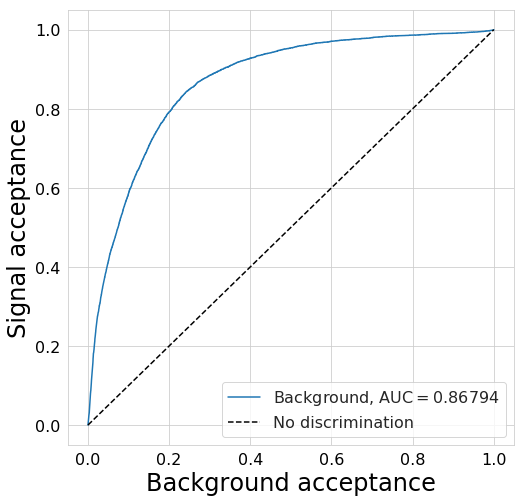

In [17]:
rocPlot([convertToDF(valData.source)], weightName='gen_weight', labels=['Background', 'Signal'])

(50000, 'candidates loaded')


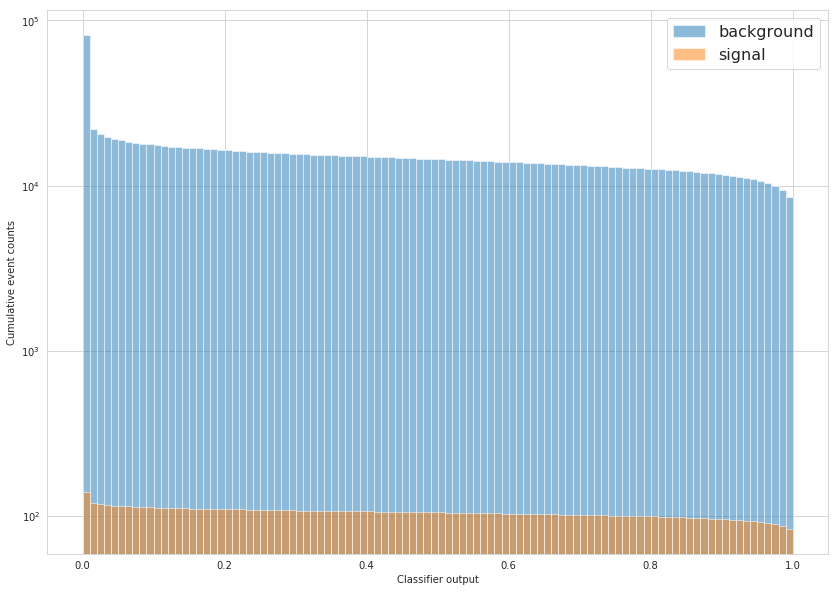

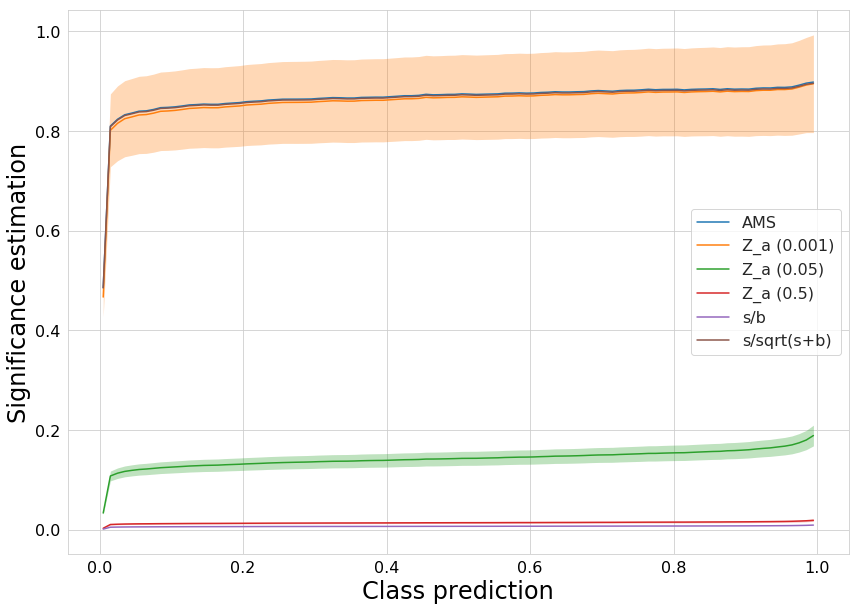

In [18]:
src = valData
#src = testData

from numpy import sqrt, log, power

def get_asimov(systematic):
    return lambda s,b: (Z_asimov(s,b, systematic), eZ_asimov(s,sqrt(s),b,sqrt(b),systematic))

h1 = plotSignificanceEstimate(
    convertToDF(src.source), 
    {
        's/b': lambda s,b: s/b,
        's/sqrt(s+b)': lambda s,b: s/np.sqrt(s+b),
        'Z_a (0.5)': get_asimov(0.5),
        'Z_a (0.05)': get_asimov(0.05),
        'Z_a (0.001)': get_asimov(0.001),
        'AMS': AMS,
#        'asimov err': lambda s,b: eZ(s,sqrt(s),b,sqrt(b)),
    },
    weightName='gen_weight',
    figsize=(14, 10),
    nBins=100,
)

In [7]:
relu = lambda x: max(x, 0)

def l(s, b, syst_factr=0.5):
    spb = s+b
    b2 = b*b
    syst = syst_factr * b
    syst2 = syst*syst
    bpsyst2 = b+syst2

#    l_val = 0.5 / np.log(
#         np.power(spb*bpsyst2/(b2+spb*syst2), spb)
#        *np.power(1 + syst2*s/(b2+b*syst2),   -b2/(syst2+1e-7))
#    )
    l_val = 0.5/(
        spb * np.log(spb*bpsyst2/(b2+spb*syst2+1e-7)+1e-7)
        -b2/(syst2+1e-7) * np.log(1+syst2*s/(b*bpsyst2+1e-7))
    )
    
#    bovers = b/s
#    
#    l_val *= relu(-relu(+bovers-1000)+1)
#    bovers *= relu(-relu(-bovers+1001)+1)  # on for x>a

    return l_val #+ bovers*100

def signifiLoss(s, b):
    return (s+b)/(s*s+1e-7)


# def l_adam(s,b,syst_factr=0.5):
#     sigB = syst_factr * b
#     return 1./(2*((s+b)*np.log((s+b)*(b+sigB*sigB)/(b*b+(s+b)*sigB*sigB+1e-7)+1e-7)-b*b*np.log(1+sigB*sigB*s/(b*(b+sigB*sigB)+1e-7))/(sigB*sigB+1e-7))) #Add the epsilon to avoid dividing by 0


#    max(min(x*1e3, 1), 0)  # on for x>1e-3    
#    max(min(1-x*1e3, 1), 0) # on for x<1e-3

In [3]:
print l(1, 900)
#print l_adam(1, 900)

5402.137972360006


In [4]:
a = 3
b = 0.5
func = lambda x: relu(-b*relu(+x-a)+1) # on for x<a
func = lambda x: relu(-b*relu(-x+a+2)+1) # on for x>a

#func = lambda x: max(min(1-x*1e3, 1)-1e-4, 0) # on for x<1e-3

In [43]:
# sanity table 0.5: 
# s_min | b_max
# 1     | 200
# 10    | 1000
# 100   | 4000
# 1000  | 20000
# 10000 | 100000

# sanity table 0.3: 
# s_min | b_max
# 1     | 300
# 10    | 1500
# 100   | 7000
# 1000  | 30000
# 10000 | 125000

# sanity table 0.1: 
# s_min | b_max
# 1     | 600
# 10    | 3000
# 100   | 15000
# 1000  | 60000
# 10000 | 300000

1


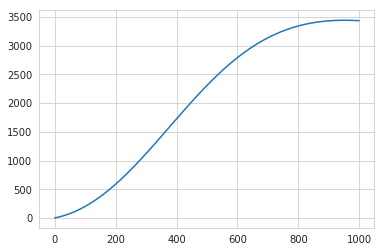

In [48]:
b = 1000
s_max = 1 #sqrt(b)
print s_max
x = np.arange(0., b, b/1000.)
y = l(s_max, x, 0.1)
y2 = signifiLoss(1, x)

#plt.semilogy(x,y)
plt.plot(x,y)
#plt.plot(x,y2)
plt.show()



/nfs/dust/cms/user/tholenhe/installs/anaconda2/envs/hepML3/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/nfs/dust/cms/user/tholenhe/installs/anaconda2/envs/hepML3/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


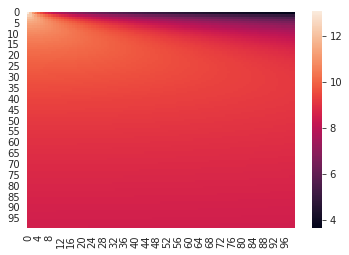

In [17]:
s = np.arange(0, 100)*.01
b = np.arange(0, 100)*10

S,B = np.meshgrid(s,b)
sns.heatmap(np.log(l(S,B)))

WARNING:tensorflow:From <ipython-input-187-f6212d07853a>:32: Print (from tensorflow.python.ops.logging_ops) is deprecated and will be removed after 2018-08-20.
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`

In [128]:
import keras.backend as K

In [144]:
a = K.eval(K.stack([K.ones((1)),
                      K.zeros((1))], axis=0))

In [145]:
a

array([[1.],
       [0.]], dtype=float32)